In [ ]:
!pip install python-dotenv yfinance statsmodels matplotlib scikit-learn tensorflow pmdarima
!pip install python-dotenv



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00


Enter the stock ticker symbol (e.g., RELIANCE.NS): RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


The Shape of the Data-Set is : (3581, 6)
The Data-Set is : 
                  Open        High         Low       Close   Adj_Close  \
Date                                                                     
2010-01-04  498.814209  498.814209  467.155457  491.682404  440.421936   
2010-01-05  525.695618  525.695618  487.065033  489.488007  438.456329   
2010-01-06  493.693939  500.368591  489.465149  497.397003  445.540802   
2010-01-07  497.397003  509.740479  492.825348  505.648834  452.932312   
2010-01-08  506.540314  509.191895  501.054321  504.323059  451.744843   

              Volume  
Date                  
2010-01-04  38323043  
2010-01-05  10696412  
2010-01-06  11845880  
2010-01-07  13098960  
2010-01-08   7555074  


--------------------------------- The Training Set is : -------------------------------------------

Date
2010-01-04     440.421936
2010-01-05     438.456329
2010-01-06     445.540802
2010-01-07     452.932312
2010-01-08     451.744843
                 ...  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)




---------------------------- ARIMA MODEL 30 Predictions-------------------------


1: 13.441212814666567

2: 16.954031851855362

3: 21.77118046868752

4: 15.033717933631733

5: 7.72004592764744

6: 9.190686125137212

7: 13.449690695832631

8: 14.301615886167946

9: 14.061618455720268

10: 12.428585911606643

11: 11.719632668965389

12: 12.319025038481684

13: 13.009175590704874

14: 13.062091985109554

15: 12.844791662138283

16: 12.563385658748814

17: 12.545712457370378

18: 12.693913206126656

19: 12.79216895016189

20: 12.770242403157395

21: 12.711583135247153

22: 12.674595053190654

23: 12.68957202827988

24: 12.718889914765487

25: 12.72918787728474

26: 12.719281200164867

27: 12.707869220329252

28: 12.704961421986205

29: 12.71022188174044

30: 12.715023282147863


---------------------------- ARIMA MODEL Summary -------------------------

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations

IndexError: index 30 is out of bounds for axis 0 with size 30

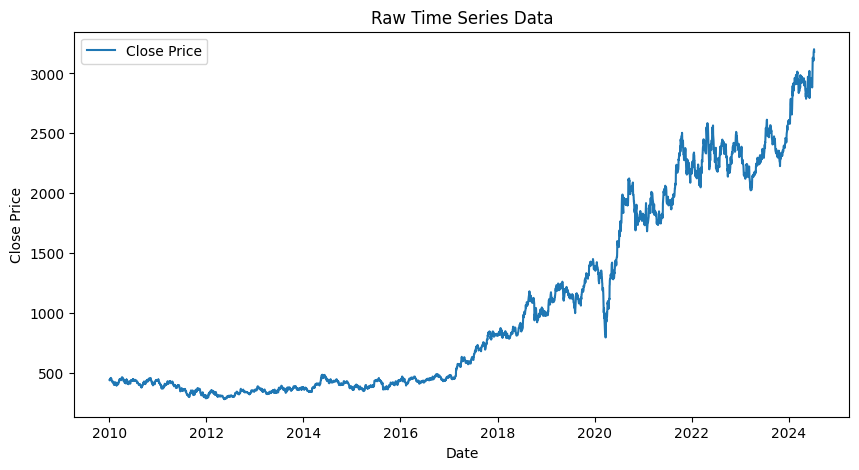

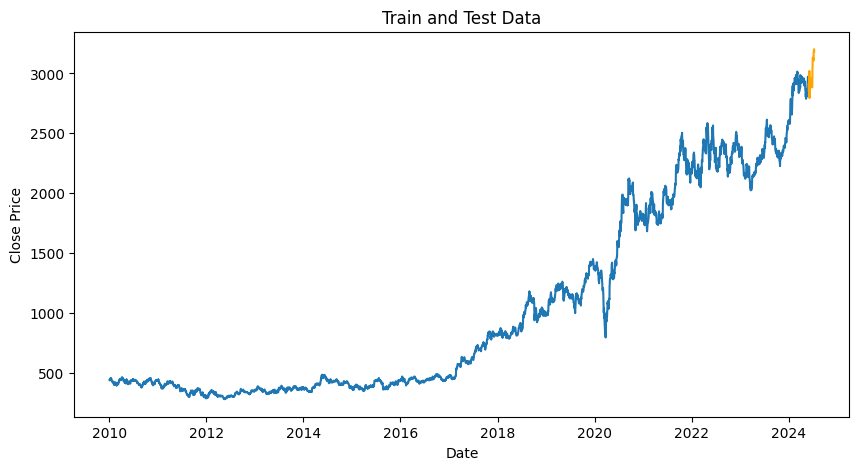

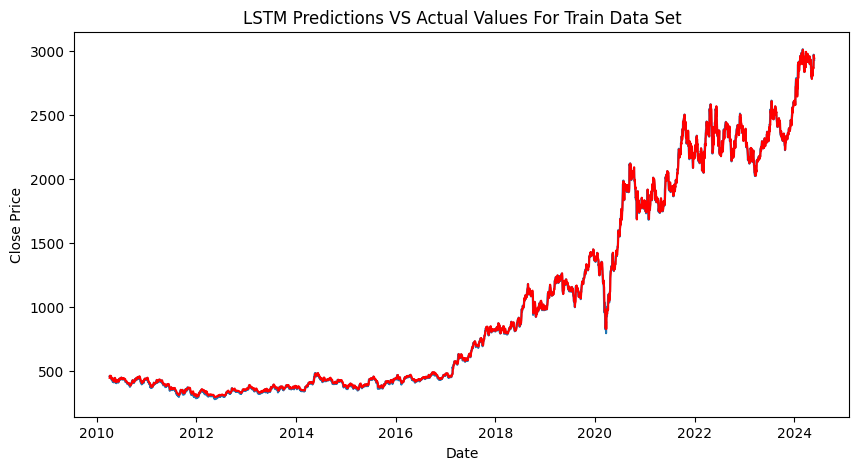

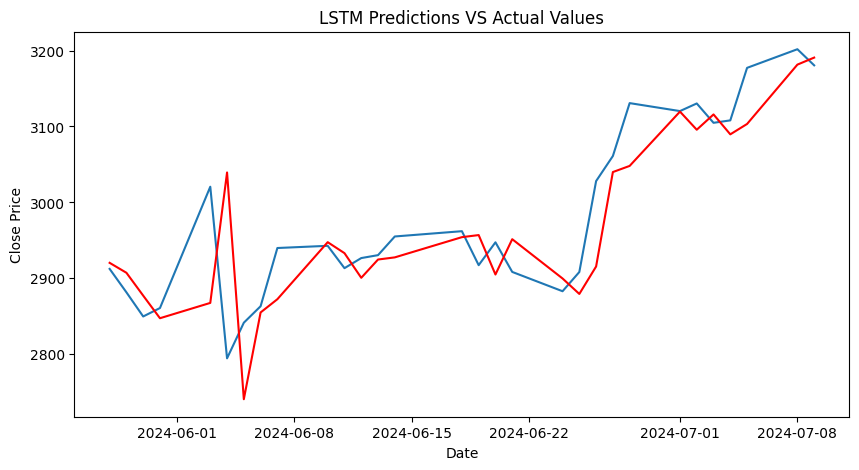

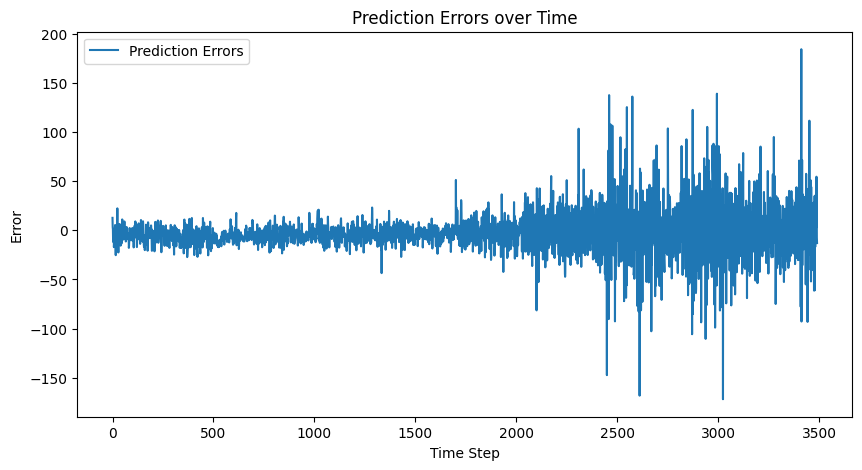

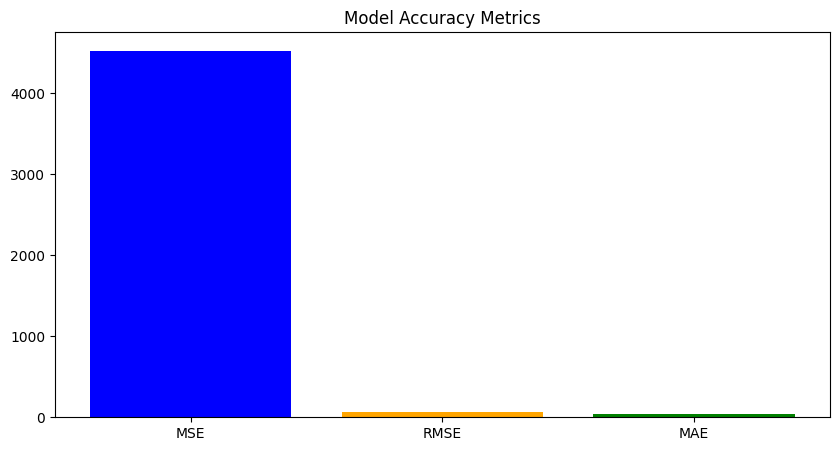

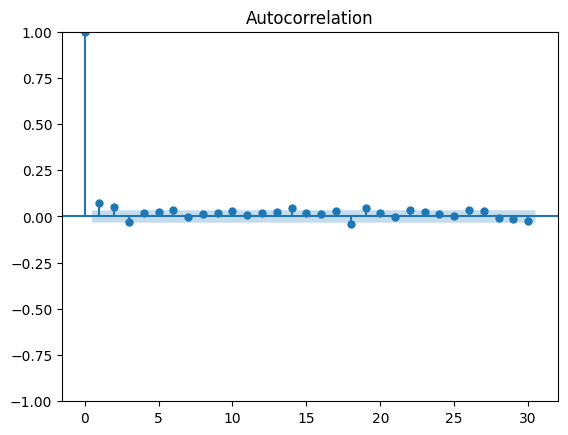

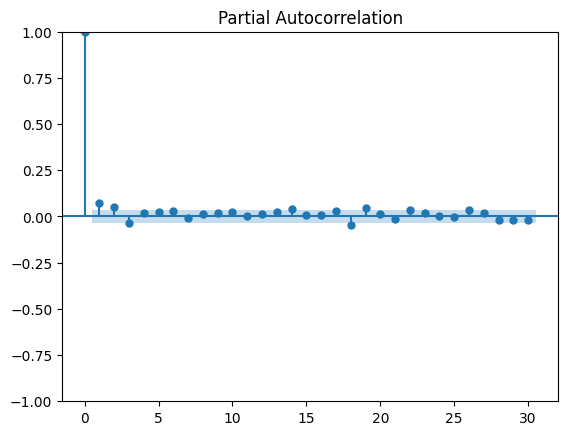

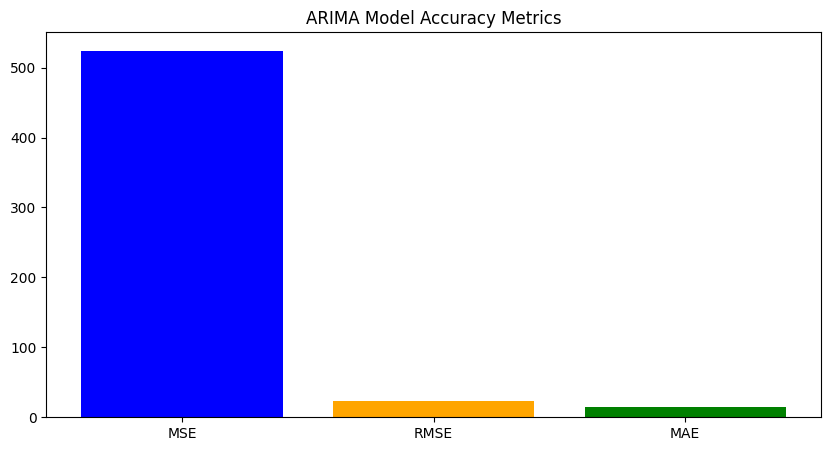

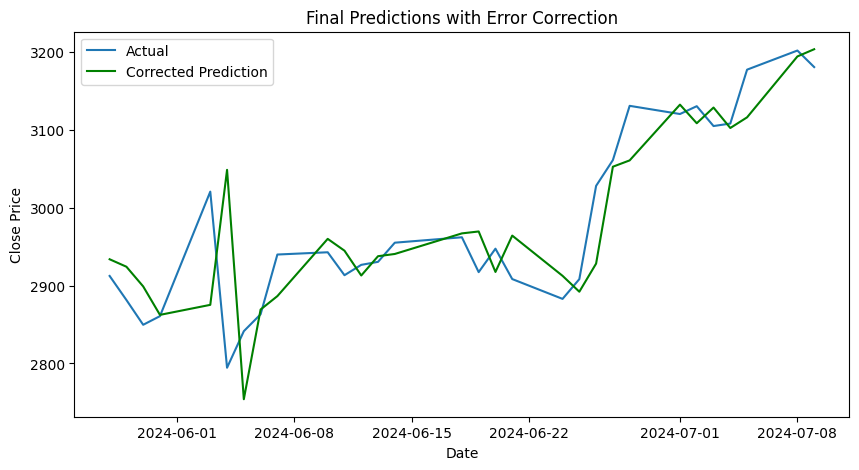

In [ ]:
import pandas as pd
import numpy as np
import os
import time
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

load_dotenv()
Output_address = os.getenv("OUTPUT_ADDRESS", "./")
close = "Adj_Close"
lag = int(os.getenv("LAG", 30))
epochs = int(os.getenv("EPOCHS", 50))
learning_rate = float(os.getenv("LEARNING_RATE", 0.001))
batch_size = int(os.getenv("BATCH_SIZE", 32))
number_nodes = int(os.getenv("NUMBER_NODES", 50))
days = int(os.getenv("PREDICTION_DAYS", 30))
n = int(os.getenv("NN_LAGS", 60))

# Function to fetch data from Yahoo Finance based on user input
def fetch_data(symbol):
    data = yf.download(symbol, start='2010-01-01', end=datetime.today().strftime('%Y-%m-%d'))
    data = data.dropna()
    data['Adj_Close'] = data['Adj Close']
    data = data[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
    print(f"The Shape of the Data-Set is : {data.shape}\nThe Data-Set is : \n{data.head()}\n")
    return data

# Plotting functions
def plot_predictions(train, predictions, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Actual')
    plt.plot(train.index, predictions, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    address = Output_address + title + ".jpg"
    plt.savefig(address)

def plot_raw_data(data):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[close], label='Close Price')
    plt.title('Raw Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    address = Output_address + 'Raw Time Series Data' + ".jpg"
    plt.savefig(address)

def plot_train_test(train, test):
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train Set')
    plt.plot(test.index, test, label='Test Set', color='orange')
    plt.title('Train and Test Data')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    address = Output_address + 'Train and Test Data' + ".jpg"
    plt.savefig(address)

def plot_prediction_errors(errors):
    plt.figure(figsize=(10, 5))
    plt.plot(errors, label='Prediction Errors')
    plt.title('Prediction Errors over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Error')
    plt.legend()
    address = Output_address + 'Prediction Errors over Time' + ".jpg"
    plt.savefig(address)

def plot_final_predictions(test, final_predictions):
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, final_predictions, label='Corrected Prediction', color='green')
    plt.title('Final Predictions with Error Correction')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    address = Output_address + 'Final Predictions with Error Correction' + ".jpg"
    plt.savefig(address)

def plot_accuracy(mse, rmse, mae):
    metrics = ['MSE', 'RMSE', 'MAE']
    values = [mse, rmse, mae]
    plt.figure(figsize=(10, 5))
    plt.bar(metrics, values, color=['blue', 'orange', 'green'])
    plt.title('Model Accuracy Metrics')
    address = Output_address + 'Model Accuracy Metrics' + ".jpg"
    plt.savefig(address)

def plot_arima_accuracy(mse, rmse, mae):
    metrics = ['MSE', 'RMSE', 'MAE']
    values = [mse, rmse, mae]
    plt.figure(figsize=(10, 5))
    plt.bar(metrics, values, color=['blue', 'orange', 'green'])
    plt.title('ARIMA Model Accuracy Metrics')
    address = Output_address + 'ARIMA Model Accuracy Metrics' + ".jpg"
    plt.savefig(address)

# Data partition for model development and training
def data_allocation(data):
    train_len_val = len(data) - days
    train, test = data[close].iloc[0:train_len_val], data[close].iloc[train_len_val:]
    print("\n--------------------------------- The Training Set is : -------------------------------------------\n")
    print(train)
    print(f"\nThe Number of Entries : {len(train)}\n")
    print("\n--------------------------------- The Testing Set is : --------------------------------------------\n")
    print(test)
    print(f"\nThe Number of Entries : {len(test)}\n")
    return train, test

# Transforming the data for the Neural Network in a lag-based matrix (nth matrix)
def apply_transform(data, n: int):
    middle_data = []
    target_data = []
    for i in range(n, len(data)):
        input_sequence = data[i-n:i]
        middle_data.append(input_sequence)
        target_data.append(data[i])
    middle_data = np.array(middle_data).reshape((len(middle_data), n, 1))  # Ensuring correct shape
    target_data = np.array(target_data).reshape(-1, 1)  # Ensuring correct shape
    return middle_data, target_data

# LSTM model training function
def LSTM(train, n: int, number_nodes, learning_rate, epochs, batch_size):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))  # Ensuring correct shape
    middle_data, target_data = apply_transform(train_scaled, n)
    model = tf.keras.Sequential([
        tf.keras.layers.Input((n, 1)),
        tf.keras.layers.LSTM(number_nodes, return_sequences=True),
        tf.keras.layers.LSTM(number_nodes),
        tf.keras.layers.Dense(units=number_nodes, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=["mean_absolute_error"])
    print(f"middle_data shape: {middle_data.shape}")
    print(f"target_data shape: {target_data.shape}")
    print(f"LSTM input shape: {model.layers[0].input_shape}")
    history = model.fit(middle_data, target_data, epochs=epochs, batch_size=batch_size, verbose=0)
    full_predictions = model.predict(middle_data)
    full_predictions = scaler.inverse_transform(full_predictions).flatten()
    return model, history, full_predictions

# Calculating accuracy of the models
def calculate_accuracy(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    return mse, rmse, mae

# Error evaluation from the LSTM model predictions
def Error_Evaluation(train_data, predict_train_data, n: int):
    errors = []
    for i in range(len(predict_train_data)):
        err = train_data[n + i] - predict_train_data[i]
        errors.append(err)
    return errors

# ARIMA parameter selection and PACF & ACF
def Parameter_calculation(data):
    finding = auto_arima(data, trace=True)
    plot_acf(data, lags=lag)
    address = Output_address + "ACF" + ".jpg"
    plt.savefig(address)
    plot_pacf(data, lags=lag)
    address = Output_address + "PACF" + ".jpg"
    plt.savefig(address)
    ord = finding.order
    return ord

# ARIMA model function for predicting the possible errors from LSTM model
def ARIMA_Model(train, len_test, ord):
    model = ARIMA(train, order=ord)
    model = model.fit()
    predictions = model.predict(start=len(train), end=len(train) + len_test - 1, typ='levels')
    full_predictions = model.predict(start=0, end=len(train)-1, typ='levels')
    return model, predictions, full_predictions

# Final prediction: LSTM predicted value + ARIMA predicted error value
def Final_Predictions(predictions_errors, predictions):
    final_values = []
    for i in range(days):
        final_values.append(predictions_errors[i] + predictions[i])
    return final_values

# Main function
def main():
    # Take stock ticker as user input
    symbol = input("Enter the stock ticker symbol (e.g., RELIANCE.NS): ")

    # Fetch data
    data = fetch_data(symbol)

    # Plot raw data
    plot_raw_data(data)

    # Allocate data to train and test sets
    train, test = data_allocation(data)

    # Plot train and test data
    plot_train_test(train, test)

    print(f"Enter the Lag Value for the Neural Network to Work: {n}\n")

    # Train LSTM model
    st1 = time.time()
    model, history, full_predictions = LSTM(train, n, number_nodes, learning_rate, epochs, batch_size)

    # Plot LSTM predictions
    plot_predictions(train[n:], full_predictions, "LSTM Predictions VS Actual Values For Train Data Set")

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))  # Ensuring correct shape
    last_sequence = train_scaled[-n:]
    predictions = []
    for i in range(days + 1):
        next_prediction = model.predict(last_sequence.reshape((1, n, 1))).flatten()[0]
        predictions.append(next_prediction)
        if i < len(test):
            actual_value = scaler.transform(test.iloc[i].reshape(-1, 1))  # Reshape correctly
            new_row = np.append(last_sequence[1:], actual_value, axis=0)
        else:
            new_row = np.append(last_sequence[1:], np.array([[next_prediction]]), axis=0)
        last_sequence = new_row

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Plot LSTM predictions vs actual values
    plot_predictions(test, predictions[:-1], "LSTM Predictions VS Actual Values")

    # Evaluate errors from LSTM predictions
    errors_data = Error_Evaluation(train.values.flatten(), full_predictions, n)
    plot_prediction_errors(errors_data)

    print(f"\n\n----------------------------- THE {days} PREDICTION VALUES FROM LSTM ---------------------------------------------------\n\n")
    for i in range(days):
        actual_value = test.iloc[i] if i < len(test) else "No actual value (out of range)"
        print(f"Day {i+1} => ACTUAL VALUE: {actual_value} | PREDICTED VALUE: {predictions[i]}\n")

    print("\n---------------------------- The LSTM Model Summary is: ----------------------------\n")
    print(model.summary())

    mse, rmse, mae = calculate_accuracy(test[:days].values, predictions[:days])
    plot_accuracy(mse, rmse, mae)

    print("\n----------------------------- LSTM MODEL ACCURACY -----------------------------\n")
    print(f"\nMEAN SQUARED ERROR: {mse}\nROOT MEAN SQUARED ERROR: {rmse}\nMEAN ABSOLUTE ERROR: {mae}\n\n")

    # ARIMA parameter calculation
    ord = Parameter_calculation(errors_data)

    # Train ARIMA model
    Arima_Model, predictions_errors, full_predictions_errors = ARIMA_Model(errors_data, len(test), ord)

    print(f"\n\n---------------------------- ARIMA MODEL {days} Predictions-------------------------\n\n")
    for i in range(len(predictions_errors)):
        print(f"{i+1}: {predictions_errors[i]}\n")

    print("\n---------------------------- ARIMA MODEL Summary -------------------------\n")
    print(Arima_Model.summary())

    arima_mse, arima_rmse, arima_mae = calculate_accuracy(errors_data, full_predictions_errors)
    plot_arima_accuracy(arima_mse, arima_rmse, arima_mae)

    print("\n\n--------------------------- FINAL PREDICTIONS ---------------------------------\n\n")
    final_predictions = Final_Predictions(predictions_errors, predictions)
    plot_final_predictions(test[:days], final_predictions[:days])
    for i in range(days):
        actual_value = test.iloc[i] if i < len(test) else "No actual value (out of range)"
        print(f"Day {i+1} => ACTUAL VALUE: {actual_value} | PREDICTED VALUE: {final_predictions[i]}\n")

    print(f"\n---------------- Difference Between the LSTM Predictions and Final Predictions of {days} days ----------------\n")
    for i in range(days):
        actual_value = test.iloc[i] if i < len(test) else "No actual value (out of range)"
        print(f"\n{i} DAY => ACTUAL VALUE: {actual_value} | LSTM PREDICTED VALUE: {predictions[i]} | FINAL PREDICTION (LSTM + ARIMA): {final_predictions[i]}\n")

    print(f"\n\n---------------- The FORECAST VALUE OF NEXT DATA POINT IS ------------------ \n\n")
    print(predictions[days] + predictions_errors[days])
    end1 = time.time()
    print(f"\n\nTime taken for model training and predictions: {end1 - st1:.2f} seconds\n\n")

    with open(os.path.join(Output_address, "output.txt"), "w+") as file:
        file.write("\n---------------- LSTM MODEL ----------------\n")
        file.write(f"The Lags Used is: {lag}\n\n")
        file.write(f"The EPOCHS is: {epochs}\n\n")
        file.write(f"The Learning-Rate of the LSTM Model is: {learning_rate}\n\n")
        file.write(f"The Batch-Size of the LSTM Model is: {batch_size}\n\n")
        file.write(f"The Number of Nodes of the LSTM Model is: {number_nodes}\n\n")
        file.write(f"The Lag Value for the Neural Network to Work: {n}\n\n")
        file.write("\n---------------------- FULL PREDICTIONS OF THE TRAIN DATA (FIRST 100 points) FROM LSTM MODEL -------------------------\n")
        for i in range(100):
            file.write(f"{i} => ACTUAL DATA POINT: {train[i]} | PREDICTED DATA POINT: {full_predictions[i]}\n")
        file.write(f"LSTM Model Summary:\n{model.summary()}\n\n")
        file.write(f"LSTM HISTORY OF THE MODEL:\n{history}\n\n")
        file.write(f"LSTM Model Mean Squared Error: {mse}\n\n")
        file.write(f"LSTM Model Root Mean Squared Error: {rmse}\n\n")
        file.write(f"LSTM Model Mean Absolute Error: {mae}\n\n")
        file.write(f"----------------------------- THE {days} PREDICTION VALUES of LSTM MODEL -----------------------------------\n\n")
        for i, (actual, pred) in enumerate(zip(test[:days].values, predictions[:days])):
            file.write(f"Day {i+1} => ACTUAL VALUE: {actual} | PREDICTED VALUE: {pred}\n\n")
        file.write("\n---------------------------- ARIMA MODEL Summary -------------------------\n")
        file.write(Arima_Model.summary().as_text())
        file.write(f"\n\n---------------------------- ARIMA MODEL {days} Predictions-------------------------\n\n")
        for i in range(len(predictions_errors)):
            file.write(f"{i} : {predictions_errors[i]}\n")
        file.write("\n\n--------------------------- FINAL PREDICTIONS ---------------------------------\n\n")
        for i in range(days):
            actual_value = test.iloc[i] if i < len(test) else "No actual value (out of range)"
            file.write(f"\nDay {i+1} => ACTUAL VALUE: {actual_value} | PREDICTED VALUE: {final_predictions[i]}\n")
        file.write(f"\n---------------- Difference Between the LSTM Predictions and Final Predictions of {days} days ----------------\n")
        for i in range(days):
            actual_value = test.iloc[i] if i < len(test) else "No actual value (out of range)"
            file.write(f"\n{i} DAY => ACTUAL VALUE: {actual_value} | LSTM PREDICTED VALUE: {predictions[i]} | FINAL PREDICTION (LSTM + ARIMA): {final_predictions[i]}\n")

        file.write(f"\nTime taken for model training and predictions: {end1 - st1:.2f} seconds\n\n")
        file.write(f"\n\n---------------- The FORECAST VALUE OF NEXT DATA POINT IS ------------------ \n\n")
        file.write(f"{predictions[days] + predictions_errors[days]}")
    print(f"Output written to {os.path.join(Output_address, 'output.txt')}")

if __name__ == '__main__':
    main()


In [ ]:
!pip install streamlit pyngrok yfinance pandas scikit-learn matplotlib tensorflow statsmodels pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import yfinance as yf
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import tensorflow as tf
import time

# Define 'close' variable
close = "Adj_Close"

# Function to fetch data from Yahoo Finance
def fetch_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    if data.empty:
        st.error(f"No data found for symbol {symbol} between {start_date} and {end_date}")
        st.stop()
    data['Adj_Close'] = data['Adj Close']
    data = data[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
    return data

# Transforming the data for the Neural Network in a lag-based matrix (nth matrix)
def apply_transform(data, n: int):
    middle_data = []
    target_data = []
    for i in range(n, len(data)):
        input_sequence = data[i-n:i]
        middle_data.append(input_sequence)
        target_data.append(data[i])
    middle_data = np.array(middle_data).reshape((len(middle_data), n, 1))  # Ensuring correct shape
    target_data = np.array(target_data).reshape(-1, 1)  # Ensuring correct shape
    return middle_data, target_data

# LSTM model training function
def LSTM(train, n: int, number_nodes, learning_rate, epochs, batch_size):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))  # Ensuring correct shape
    middle_data, target_data = apply_transform(train_scaled, n)
    model = tf.keras.Sequential([
        tf.keras.layers.Input((n, 1)),
        tf.keras.layers.LSTM(number_nodes, return_sequences=True),
        tf.keras.layers.LSTM(number_nodes),
        tf.keras.layers.Dense(units=number_nodes, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=["mean_absolute_error"])
    history = model.fit(middle_data, target_data, epochs=epochs, batch_size=batch_size, verbose=0)
    full_predictions = model.predict(middle_data)
    full_predictions = scaler.inverse_transform(full_predictions).flatten()
    return model, history, full_predictions, scaler

# Calculating accuracy of the models
def calculate_accuracy(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    return mse, rmse, mae

# Error evaluation from the LSTM model predictions
def Error_Evaluation(train_data, predict_train_data, n: int):
    errors = []
    for i in range(len(predict_train_data)):
        err = train_data[n + i] - predict_train_data[i]
        errors.append(err)
    return errors

# ARIMA model function for predicting the possible errors from LSTM model
def ARIMA_Model(train, len_test, ord):
    model = ARIMA(train, order=ord)
    model = model.fit()
    predictions = model.predict(start=len(train), end=len(train) + len_test - 1, typ='levels')
    full_predictions = model.predict(start=0, end=len(train)-1, typ='levels')
    return model, predictions, full_predictions

# Final prediction: LSTM predicted value + ARIMA predicted error value
def Final_Predictions(predictions_errors, predictions):
    min_length = min(len(predictions_errors), len(predictions))
    final_values = []
    for i in range(min_length):
        final_values.append(predictions_errors[i] + predictions[i])
    return final_values

st.title("Stock Price Prediction")

# User inputs
symbol = st.text_input("Enter Stock Ticker Symbol (e.g., RELIANCE.NS):", value="RELIANCE.NS")
start_date = st.date_input("Select Start Date:", value=datetime(2010, 1, 1))
end_date = st.date_input("Select End Date:", value=datetime.today())
days = st.number_input("Number of Days to Predict:", min_value=1, value=30)
lag = st.number_input("Lag Value for LSTM Model:", min_value=1, value=60)
epochs = st.number_input("Number of Epochs:", min_value=1, value=50)
learning_rate = st.number_input("Learning Rate:", min_value=0.0001, value=0.001, format="%.4f")
batch_size = st.number_input("Batch Size:", min_value=1, value=32)
number_nodes = st.number_input("Number of Nodes:", min_value=1, value=50)

if st.button("Predict"):
    with st.spinner("Fetching data and training model..."):
        data = fetch_data(symbol, start_date, end_date)

        train_len_val = len(data) - days
        train, test = data[close].iloc[0:train_len_val], data[close].iloc[train_len_val:]

        # Train LSTM model
        st1 = time.time()
        model, history, full_predictions, scaler = LSTM(train, lag, number_nodes, learning_rate, epochs, batch_size)

        train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
        last_sequence = train_scaled[-lag:]
        predictions = []
        for i in range(days + 1):
            next_prediction = model.predict(last_sequence.reshape((1, lag, 1))).flatten()[0]
            predictions.append(next_prediction)
            if i < len(test):
                actual_value = scaler.transform(np.array(test.iloc[i]).reshape(-1, 1))  # Reshape correctly
                new_row = np.append(last_sequence[1:], actual_value, axis=0)
            else:
                new_row = np.append(last_sequence[1:], np.array([[next_prediction]]), axis=0)
            last_sequence = new_row

        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

        # Evaluate errors from LSTM predictions
        errors_data = Error_Evaluation(train.values.flatten(), full_predictions, lag)

        # ARIMA parameter calculation
        ord = auto_arima(errors_data, trace=True).order

        # Train ARIMA model
        Arima_Model, predictions_errors, full_predictions_errors = ARIMA_Model(errors_data, len(test), ord)

        final_predictions = Final_Predictions(predictions_errors, predictions)

        st.success("Prediction complete!")

        # Plot the results
        st.subheader("LSTM Predictions vs Actual Values")
        fig, ax = plt.subplots()
        ax.plot(test.index, test.values, label='Actual', color='blue')
        ax.plot(test.index, predictions[:-1], label='LSTM Predictions', color='red')
        plt.xticks(rotation=45)
        st.pyplot(fig)

        # Plot the future predictions
        st.subheader("Future Predictions")
        future_dates = pd.date_range(start=test.index[-1], periods=days+1, closed='right')
        fig, ax = plt.subplots()
        ax.plot(data.index, data[close], label='Historical Prices', color='blue')
        ax.plot(future_dates, predictions[1:], label='Future Predictions', color='red')
        plt.xticks(rotation=45)
        st.pyplot(fig)

        st.subheader("Final Predictions with Error Correction")
        fig, ax = plt.subplots()
        ax.plot(test.index, test.values, label='Actual', color='blue')
        ax.plot(test.index, final_predictions[:len(test)], label='Final Predictions', color='green')
        plt.xticks(rotation=45)
        st.pyplot(fig)

        mse, rmse, mae = calculate_accuracy(test[:days].values, predictions[:days])
        st.write(f"LSTM Model Mean Squared Error: {mse}")
        st.write(f"LSTM Model Root Mean Squared Error: {rmse}")
        st.write(f"LSTM Model Mean Absolute Error: {mae}")

        arima_mse, arima_rmse, arima_mae = calculate_accuracy(errors_data, full_predictions_errors)
        st.write(f"ARIMA Model Mean Squared Error: {arima_mse}")
        st.write(f"ARIMA Model Root Mean Squared Error: {arima_rmse}")
        st.write(f"ARIMA Model Mean Absolute Error: {arima_mae}")

        end1 = time.time()
        st.write(f"Time taken for model training and predictions: {end1 - st1:.2f} seconds")


Overwriting app.py


Streamlit App URL: https://01b6-35-221-235-254.ngrok-free.app



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.235.254:8501

2024-07-05 11:52:17.731874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 11:52:17.731950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 11:52:17.734723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 11:52:20.389667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[*

In [ ]:
!pip install streamlit pyngrok

import os
from pyngrok import ngrok

# Set up Ngrok authentication
authtoken = "2iUw4PqBtMWS8y0U2BhlmhXVxt5_4jsngK9CVZXgXgGKx8YAM"  # Replace with your ngrok authtoken
ngrok.set_auth_token(authtoken)

# Terminate any existing ngrok tunnels
ngrok.kill()

# Run the Streamlit app, explicitly specifying the port
public_url = ngrok.connect(8501)  # Directly pass the port number
print(f"Streamlit App URL: {public_url}")

!streamlit run app.py

Streamlit App URL: NgrokTunnel: "https://9336-35-221-235-254.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.235.254:8501

2024-07-05 12:03:24.736470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 12:03:24.736546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 12:03:24.738821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 12:03:26.666636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 